In [ ]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 

In [ ]:
from datasets import load_dataset

# Loads train/validation/test splits with translation field
dataset = load_dataset("agentlans/en-fr")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.72k [00:00<?, ?B/s]

train.jsonl.zst:   0%|          | 0.00/149M [00:00<?, ?B/s]

test.jsonl.zst:   0%|          | 0.00/37.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1686856 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/421715 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
        num_rows: 1686856
    })
    test: Dataset({
        features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
        num_rows: 421715
    })
})


In [ ]:
small_train = dataset["train"].shuffle(seed=42).select(range(14_000))
small_test = dataset["test"].shuffle(seed=42).select(range(5_000))

In [ ]:
small_dataset = {
    "train": small_train,
    "test": small_test
}

In [ ]:
print(small_dataset["train"][0])
print(len(small_dataset["train"]))  
print(len(small_dataset["test"]))   

{'id': 526884, 'english': 'The project will also involve extensive demonstration carried out within the framework of TEN-TELECOM, which provides a series of guidelines for developing trans-European telecommunications networks.', 'french': "Le projet fera également appel à d'importantes activités de démonstration menées dans le cadre de RTE-TELECOM, qui fournit un ensemble d'orientations pour le développement des réseaux transeuropéens de télécommunications.", 'source': 'ELRC-1118-CORDIS_News', 'translation_quality': 0.8736, 'readability_grade': 19.24}
14000
5000


In [ ]:
split_2=small_dataset['test'].train_test_split(test_size=0.5,seed=42)

validation_dataset=split_2["train"]

test_dataset=split_2["test"]

print(f"Length of the validation dataset: {len(validation_dataset)}")

print(f"Length of the test dataset: {len(test_dataset)}")

Length of the validation dataset: 2500
Length of the test dataset: 2500


In [ ]:
train_dataset=small_dataset["train"]
print(train_dataset)

Dataset({
    features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
    num_rows: 14000
})


In [ ]:
from datasets import DatasetDict

final_dataset=DatasetDict({
    "train":train_dataset,
    "validation":validation_dataset,
    "test":test_dataset
})

print(final_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
        num_rows: 14000
    })
    validation: Dataset({
        features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
        num_rows: 2500
    })
    test: Dataset({
        features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
        num_rows: 2500
    })
})


In [ ]:
##converting to csv for flexible usage

train_dataset=final_dataset["train"].to_pandas()

validation_dataset=final_dataset["validation"].to_pandas()

test_dataset=final_dataset["test"].to_pandas()

In [ ]:
train_dataset.drop(['id','source','translation_quality','readability_grade'],axis=1,inplace=True)

validation_dataset.drop(['id','source','translation_quality','readability_grade'],axis=1,inplace=True)

test_dataset.drop(['id','source','translation_quality','readability_grade'],axis=1,inplace=True)

In [ ]:
train_dataset.columns=['en','fr']

validation_dataset.columns=['en','fr']

test_dataset.columns=['en','fr']

In [ ]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 62.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

# Load SpaCy tokenizers
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_sm")


In [ ]:
def tokenize_spacy(text, nlp):
    return [token.text for token in nlp(text.strip()) if not token.is_space]

In [ ]:
from collections import Counter

def build_vocab_spacy(sentences, nlp, min_freq=1):
    counter = Counter()
    for sentence in sentences:
        tokens = tokenize_spacy(sentence, nlp)
        counter.update(tokens)

    vocab = {"<pad>": 0, "<unk>": 1, "<sos>": 2, "<eos>": 3}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

In [ ]:
en_vocab = build_vocab_spacy(train_dataset["en"], nlp_en)
fr_vocab = build_vocab_spacy(train_dataset["fr"], nlp_fr)

In [ ]:
MAX_LEN = 100

def encode_spacy(sentence, vocab, nlp, max_len=MAX_LEN):
    tokens = ["<sos>"] + tokenize_spacy(sentence, nlp) + ["<eos>"]
    token_ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    token_ids = token_ids[:max_len]
    token_ids += [vocab["<pad>"]] * (max_len - len(token_ids))
    return token_ids

In [ ]:
# Train Set
train_dataset["input_ids_en"] = train_dataset["en"].apply(lambda x: encode_spacy(x, en_vocab, nlp_en))
train_dataset["input_ids_fr"] = train_dataset["fr"].apply(lambda x: encode_spacy(x, fr_vocab, nlp_fr))

# Validation Set
validation_dataset["input_ids_en"] = validation_dataset["en"].apply(lambda x: encode_spacy(x, en_vocab, nlp_en))
validation_dataset["input_ids_fr"] = validation_dataset["fr"].apply(lambda x: encode_spacy(x, fr_vocab, nlp_fr))

# Test Set
test_dataset["input_ids_en"] = test_dataset["en"].apply(lambda x: encode_spacy(x, en_vocab, nlp_en))
test_dataset["input_ids_fr"] = test_dataset["fr"].apply(lambda x: encode_spacy(x, fr_vocab, nlp_fr))


In [ ]:
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, encoded_en, encoded_fr):
        self.en_data = encoded_en
        self.fr_data = encoded_fr

    def __len__(self):
        return len(self.en_data)

    def __getitem__(self, idx):
        return {
            "input_ids_en": torch.tensor(self.en_data[idx], dtype=torch.long),
            "input_ids_fr": torch.tensor(self.fr_data[idx], dtype=torch.long)
        }


In [ ]:
"""Okay-system calculations very important-utilizing the GPU"""
import torch

device='cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [ ]:
"""Generating iterators for the dataloader that would load the data in batches whilst training, first lets just create a cutom dataset from the encoded_train
(tokenized pre-processed dataset)"""

train_dataset_pt = TranslationDataset(
    train_dataset["input_ids_en"].tolist(),
    train_dataset["input_ids_fr"].tolist()
)

train_loader = DataLoader(train_dataset_pt, batch_size=4, shuffle=True,num_workers=2,pin_memory='cuda')


In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_layers=2, embed_dim=768, pad_token_id=0):
        super().__init__()

        # Trainable Embedding Layer
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_token_id
        )

        # Bidirectional LSTM
        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )

    def forward(self, input_ids):
        # input_ids: (batch_size, seq_len)
        embedded = self.embedding(input_ids)  # (batch_size, seq_len, embed_dim)
        output, (hidden, cell) = self.bilstm(embedded)  # hidden: (num_layers*2, batch_size, hidden_dim)

        # Concatenate last forward and backward hidden states from the final LSTM layer
        # hidden[-2] = forward final layer, hidden[-1] = backward final layer
        last_fwd = hidden[-2]  # (batch_size, hidden_dim)
        last_bwd = hidden[-1]  # (batch_size, hidden_dim)
        final_hidden = torch.cat((last_fwd, last_bwd), dim=1)  # (batch_size, hidden_dim*2)

        return final_hidden


In [ ]:
class BridgeLayer(nn.Module):
    def __init__(self, encoder_output_dim, decoder_hidden_dim, num_layers=2):
        super().__init__()
        self.hidden_fc = nn.Linear(encoder_output_dim, decoder_hidden_dim)
        self.cell_fc = nn.Linear(encoder_output_dim, decoder_hidden_dim)
        self.num_layers = num_layers

    def forward(self, encoder_final):
        """
        Args:
            encoder_final: (batch_size, encoder_output_dim)

        Returns:
            h_0: (num_layers, batch_size, decoder_hidden_dim)
            c_0: (num_layers, batch_size, decoder_hidden_dim)
        """
        h_0_single = self.hidden_fc(encoder_final).unsqueeze(0)  # (1, batch, hidden_dim)
        c_0_single = self.cell_fc(encoder_final).unsqueeze(0)

        h_0 = h_0_single.repeat(self.num_layers, 1, 1)  # (num_layers, batch, hidden_dim)
        c_0 = c_0_single.repeat(self.num_layers, 1, 1)

        return h_0, c_0

In [ ]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, pad_token_id, bos_token_id, eos_token_id,
                 num_layers=2, max_len=90, embed_dim=768, device='cuda'):
        super().__init__()

        self.device = device
        self.vocab_size = output_dim
        self.embedding_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.max_len = max_len
        self.num_layers = num_layers

        self.pad_token_id = pad_token_id
        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=pad_token_id)

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )

        self.fc = nn.Linear(hidden_dim, self.vocab_size)

    def forward(self, input_ids_decoder, h_0, c_0):
        """
        Args:
            input_ids_decoder: (batch_size, tgt_seq_len)
            h_0, c_0: (num_layers, batch_size, hidden_dim) — from BridgeLayer
        """
        embeddings = self.embedding(input_ids_decoder)  # (batch_size, seq_len, embed_dim)
        lstm_out, _ = self.lstm(embeddings, (h_0, c_0))
        logits = self.fc(lstm_out)  # (batch_size, seq_len, vocab_size)
        return logits

    def generate(self, h_0, c_0):
        """
        Greedy decoding using initial hidden and cell states from BridgeLayer.
        """
        self.eval()
        batch_size = h_0.size(1)

        generated_ids = torch.full((batch_size, 1), self.bos_token_id, dtype=torch.long).to(self.device)
        finished = torch.zeros(batch_size, dtype=torch.bool).to(self.device)

        for _ in range(self.max_len):
            embeddings = self.embedding(generated_ids[:, -1:])  # Only last token
            lstm_out, (h_0, c_0) = self.lstm(embeddings, (h_0, c_0))

            logits = self.fc(lstm_out[:, -1, :])  # (batch, vocab)
            next_token_id = torch.argmax(logits, dim=-1).unsqueeze(1)

            generated_ids = torch.cat((generated_ids, next_token_id), dim=1)
            finished |= (next_token_id.squeeze() == self.eos_token_id)
            if finished.all():
                break

        return generated_ids[:, 1:]  # remove <bos>


In [ ]:
import nltk
nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm

encoder_model = Encoder(
    vocab_size=len(en_vocab),
    hidden_dim=512,
    num_layers=2,
    embed_dim=768,
    pad_token_id=en_vocab["<pad>"]
).to(device)

bridge_layer = BridgeLayer(
    encoder_output_dim=1024,
    decoder_hidden_dim=512,
    num_layers=2  # Match decoder layers
).to(device)

decoder_model = Decoder(
    hidden_dim=512,
    output_dim=len(fr_vocab),
    pad_token_id=fr_vocab["<pad>"],
    bos_token_id=fr_vocab["<sos>"],
    eos_token_id=fr_vocab["<eos>"],
    embed_dim=768,
    num_layers=2,
    max_len=90,
    device=device
).to(device)

params = list(encoder_model.parameters()) + \
         list(bridge_layer.parameters()) + \
         list(decoder_model.parameters())

optimizer = torch.optim.Adam(params, lr=0.0003)
criterion = nn.CrossEntropyLoss(ignore_index=fr_vocab["<pad>"])
epochs = 14
losses = []

for epoch in range(epochs):
    encoder_model.train()
    bridge_layer.train()
    decoder_model.train()

    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids_en = batch["input_ids_en"].to(device)
        input_ids_fr = batch["input_ids_fr"].to(device)

        optimizer.zero_grad()

        encoder_out = encoder_model(input_ids_en)  # (batch_size, 1024)

        h_0, c_0 = bridge_layer(encoder_out)  # (num_layers, batch, hidden_dim)

        decoder_out = decoder_model(input_ids_fr, h_0, c_0)  # (batch, seq, vocab)

        target_ids = input_ids_fr[:, 1:]            # remove <sos>
        predicted_logits = decoder_out[:, :-1, :]   # remove last time step

        #Compute loss
        loss = criterion(
            predicted_logits.reshape(-1, predicted_logits.size(-1)),
            target_ids.reshape(-1)
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")


100%|██████████| 3500/3500 [04:47<00:00, 12.15it/s]


Epoch 1 - Avg Loss: 6.2260


100%|██████████| 3500/3500 [04:51<00:00, 12.01it/s]


Epoch 2 - Avg Loss: 5.2407


100%|██████████| 3500/3500 [04:51<00:00, 12.00it/s]


Epoch 3 - Avg Loss: 4.7041


100%|██████████| 3500/3500 [04:50<00:00, 12.06it/s]


Epoch 4 - Avg Loss: 4.2146


100%|██████████| 3500/3500 [04:49<00:00, 12.07it/s]


Epoch 5 - Avg Loss: 3.7567


100%|██████████| 3500/3500 [04:49<00:00, 12.09it/s]


Epoch 6 - Avg Loss: 3.3061


100%|██████████| 3500/3500 [04:49<00:00, 12.08it/s]


Epoch 7 - Avg Loss: 2.8722


100%|██████████| 3500/3500 [04:50<00:00, 12.07it/s]


Epoch 8 - Avg Loss: 2.4753


100%|██████████| 3500/3500 [04:49<00:00, 12.08it/s]


Epoch 9 - Avg Loss: 2.1177


100%|██████████| 3500/3500 [04:49<00:00, 12.09it/s]


Epoch 10 - Avg Loss: 1.7956


100%|██████████| 3500/3500 [04:50<00:00, 12.04it/s]


Epoch 11 - Avg Loss: 1.5112


100%|██████████| 3500/3500 [04:50<00:00, 12.06it/s]


Epoch 12 - Avg Loss: 1.2626


100%|██████████| 3500/3500 [04:50<00:00, 12.07it/s]


Epoch 13 - Avg Loss: 1.0429


100%|██████████| 3500/3500 [04:49<00:00, 12.08it/s]

Epoch 14 - Avg Loss: 0.8560


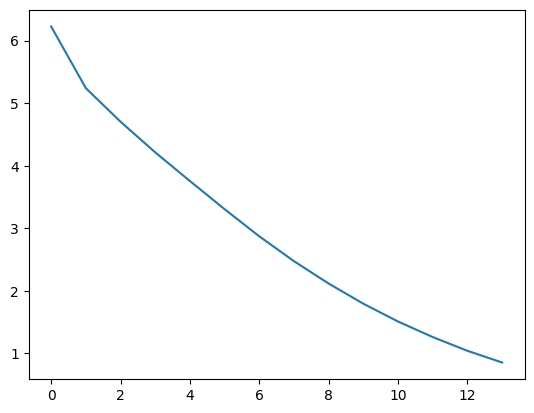

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(14),losses)
plt.show()

In [ ]:
val_dataset_pt = TranslationDataset(
    validation_dataset["input_ids_en"].tolist(),
    validation_dataset["input_ids_fr"].tolist()
)

test_dataset_pt = TranslationDataset(
    test_dataset["input_ids_en"].tolist(),
    test_dataset["input_ids_fr"].tolist()
)

In [ ]:
val_loader = DataLoader(val_dataset_pt, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset_pt, batch_size=2, shuffle=False)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm

def decode_sentence(token_ids, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    tokens = []
    for token_id in token_ids:
        token = inv_vocab.get(token_id.item(), "<unk>")
        if token in ["<pad>", "<sos>"]:
            continue
        if token == "<eos>":
            break
        tokens.append(token)
    return tokens

def evaluate_bleu(encoder_model, bridge_layer, decoder_model, dataloader, en_vocab, fr_vocab, device):
    encoder_model.eval()
    bridge_layer.eval()
    decoder_model.eval()

    references = []
    hypotheses = []

    smoothie = SmoothingFunction().method4  # Apply BLEU smoothing

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids_en = batch["input_ids_en"].to(device)
            input_ids_fr = batch["input_ids_fr"].to(device)

            #Encode + bridge
            encoder_out = encoder_model(input_ids_en)
            h_0, c_0 = bridge_layer(encoder_out)

            # Generate from decoder with proper initial state
            generated_ids = decoder_model.generate(h_0, c_0)

            for gen, tgt in zip(generated_ids, input_ids_fr):
                pred_tokens = decode_sentence(gen, fr_vocab)
                tgt_tokens = decode_sentence(tgt, fr_vocab)

                hypotheses.append(pred_tokens)
                references.append([tgt_tokens])  # List of one reference per sentence

    # Use smoothing in case of short matches or rare n-gram overlaps
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
    return bleu_score

In [ ]:
val_bleu = evaluate_bleu(encoder_model, bridge_layer, decoder_model, val_loader, en_vocab, fr_vocab, device)
print(f"Validation BLEU Score: {val_bleu:.4f}")

test_bleu = evaluate_bleu(encoder_model, bridge_layer, decoder_model, test_loader, en_vocab, fr_vocab, device)
print(f"Test BLEU Score: {test_bleu:.4f}")

100%|██████████| 1250/1250 [00:57<00:00, 21.56it/s]


Validation BLEU Score: 0.0135


100%|██████████| 1250/1250 [00:57<00:00, 21.65it/s]


Test BLEU Score: 0.0147
